In [1]:
import numpy as np
import torch
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
loc = ""
train_file_data, dev_file_data, test_file_data = None,None,None

# opening the train,test,dev data to read it
with open(loc+"data/train",'r',encoding='utf8') as f:
    train_file_data = f.read().split("\n")
    
with open(loc+'data/dev','r',encoding='utf8') as f:
    dev_file_data = f.read().split("\n")
    
with open(loc+'data/test','r',encoding='utf8') as f:
    test_file_data = f.read().split("\n")

# setting threshold for the min frequency of words in the vocab
thresh = 0
vocab = {}
for line in train_file_data:
    if line!='':
        d = line.split(' ')
        # incrementing the frequency in vocab as we encounter the word
        vocab[d[1]] = vocab.get(d[1], 0) + 1
        
unk = 0
words=[]
# creating a words list to account for minimum frequency threshold
for k,v in vocab.items():
    if v>thresh:
        words.append([v,k])
    else:
        unk+=1

# creating a vocab dictionary for word frequency
vocab = {}
vocab["<unk>"] = unk
for i,v in enumerate(sorted(words, reverse=True)):
    vocab[v[1]] = v[0]

In [3]:
tags = {}
for w in train_file_data:
    if w!='':
        d = w.split(' ')
        if d[1] in vocab:
            tags[d[2]] = tags.get(d[2], 0) + 1
        
tag_enc = {k:v for v,k in enumerate(list(tags.keys()))}
tag_enc['<pad>'] = -1
vocab_enc = {k:v for v,k in enumerate(['<pad>']+list(vocab.keys()))}
tag_dec = list(tag_enc.keys())
vocab_dec = list(vocab_enc.keys())

sent, label = [], []
X_train, y_train = [], []
for w in train_file_data:
    if w=='':
        X_train.append(np.array(sent))
        y_train.append(np.array(label))
        sent,label=[],[]
    else:
        d = w.split(' ')
        sent.append(d[1])
        label.append(d[2])
        
sent, label = [], []
X_dev, y_dev = [], []
for w in dev_file_data:
    if w=='':
        X_dev.append(np.array(sent))
        y_dev.append(np.array(label))
        sent,label=[],[]
    else:
        d = w.split(' ')
        sent.append(d[1])
        label.append(d[2])
        
sent = []
X_test = []
for w in test_file_data:
    if w=='':
        X_test.append(np.array(sent))
        sent=[]
    else:
        d = w.split(' ')
        sent.append(d[1])


In [4]:
class Model_Data(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sent = self.X[idx][0].long().to(device)
        ner = self.y[idx].long().to(device) if len(self.y)!=0 else []
        le = self.X[idx][1]
        return sent, ner, le, idx

# Task 1: Simple Bidirectional LSTM

In [5]:
def enc_sent(x,voc):
    return np.array([voc.get(w, voc['<unk>']) for w in x])

def enc_tags(x,tag):
    return np.array([tag.get(w) for w in x])

# how many samples per batch to load
batch_size = 16

X_train_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent(x,vocab_enc)) for x in X_train], batch_first=True, padding_value=vocab_enc['<pad>'])
X_train_pad = [[x,len(l)] for x,l in zip(X_train_pad,X_train)]
y_train_torch = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_tags(y_,tag_enc)) for y_ in y_train], batch_first=True, padding_value=tag_enc['<pad>'])

X_dev_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent(x,vocab_enc)) for x in X_dev], batch_first=True, padding_value=vocab_enc['<pad>'])
X_dev_pad = [[x,len(l)] for x,l in zip(X_dev_pad,X_dev)]
y_dev_torch = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_tags(y_,tag_enc)) for y_ in y_dev], batch_first=True, padding_value=tag_enc['<pad>'])

X_test_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent(x,vocab_enc)) for x in X_test], batch_first=True, padding_value=vocab_enc['<pad>'])
X_test_pad = [[x,len(l)] for x,l in zip(X_test_pad,X_test)]

train_data = Model_Data(X_train_pad,y_train_torch)
dev_data = Model_Data(X_dev_pad,y_dev_torch)
test_data = Model_Data(X_test_pad,[])

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [6]:
class BLSTM(torch.nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden, n_layers, linear_op_size, n_classes, dropout, pad_idx):
        super(BLSTM, self).__init__()
        self.hidden_dim = hidden
        self.num_layers = n_layers
        self.emb = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx=pad_idx)
        self.bilstm = torch.nn.LSTM(input_size=emb_dim, hidden_size=hidden, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.drop = torch.nn.Dropout(dropout)
        self.linear1 = torch.nn.Linear(2*hidden, linear_op_size)
        self.elu = torch.nn.ELU()
        self.linear2 = torch.nn.Linear(linear_op_size, n_classes)
        
    def forward(self, x, l):
        # Initializing hidden state for first input with zeros
        x = self.emb(x)
        
        x_pack = torch.nn.utils.rnn.pack_padded_sequence(x, l, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.bilstm(x_pack)
        lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        
        lstm_out = self.drop(lstm_out)

        x = self.linear1(lstm_out)
        x = self.elu(x)
        x = self.linear2(x)
        return x

In [7]:
def train(n_epochs,n_classes,model,criterion,optimizer,tag_enc,training_loader,dev_loader,model_name):

    # initialize tracker for minimum validation loss
    train_f1 = [0]
    dev_f1 = [0]
    losses = [np.Inf]

    train_loss_min = np.Inf # set initial "min" to infinity
        
    for epoch in range(n_epochs):
        # monitor training loss
        
        train_loss = 0
        model.train() # prep model for training

        pred, truth = [], []
        for data, target, length, _ in tqdm(training_loader):
            
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data, length)

            predicted = torch.argmax(output, 2)
            [[pred.append(x.item()) for x in p[:t]] for p,t in zip(predicted,length)]
            [[truth.append(x.item()) for x in i[:t]] for i,t in zip(target,length)]

            target = target[:,:max(length)].clone()
            loss = criterion(output.view(-1, n_classes), target.long().view(-1))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
  
        train_f1.append(f1_score(truth,pred,labels=list(tag_enc.values()),average='macro',zero_division=0))

        pred, truth = [], []
        for x, y, l, _ in dev_loader:
            outputs = model(x,l)
            predicted = torch.argmax(outputs, 2)
            [[pred.append(x.item()) for x in p[:t]] for p,t in zip(predicted,l)]
            [[truth.append(x.item()) for x in i[:t]] for i,t in zip(y,l)]

        dev_f1.append(f1_score(truth,pred,labels=list(tag_enc.values()),average='macro',zero_division=0))
        
        train_loss = train_loss/len(training_loader.dataset)
        losses.append(train_loss)

        print('Epoch: {} of {}, \tTraining Loss: {:.6f}'.format(epoch+1,n_epochs,train_loss))

        # save model if validation loss has decreased
        if train_loss <= train_loss_min:
            print('Training loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            train_loss_min,
            train_loss))
            torch.save(model.state_dict(), model_name)
            train_loss_min = train_loss

    return train_f1, dev_f1, losses

In [8]:
vocab_size=len(vocab_enc.keys())
pad_idx=vocab_enc['<pad>']
emb_dim=100 
hidden_size=256 
num_layers=1
linear_op_size=128
num_classes=len(tag_enc.keys())-1 # exclude the tag class
dropout = 0.33
pad_idx = vocab_enc['<pad>']
class_weights = torch.tensor([(1-v/sum(tags.values())) for v in tags.values()]).to(device)

blstmClassifier = BLSTM(vocab_size, emb_dim, hidden_size, num_layers, linear_op_size, num_classes, dropout, pad_idx) 
blstmClassifier.to(device)
print(blstmClassifier)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights,ignore_index=tag_enc['<pad>'])
optimizer = torch.optim.SGD(blstmClassifier.parameters(), lr=0.1, momentum=0.9) 
n_epochs = 60

BLSTM(
  (emb): Embedding(23626, 100, padding_idx=0)
  (bilstm): LSTM(100, 256, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.33, inplace=False)
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (elu): ELU(alpha=1.0)
  (linear2): Linear(in_features=128, out_features=9, bias=True)
)


100%|██████████| 937/937 [00:15<00:00, 58.84it/s]


Epoch: 1 of 60, 	Training Loss: 1.352023
Training loss decreased (inf --> 1.352023).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 58.69it/s]


Epoch: 2 of 60, 	Training Loss: 0.823325
Training loss decreased (1.352023 --> 0.823325).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 57.61it/s]


Epoch: 3 of 60, 	Training Loss: 0.489906
Training loss decreased (0.823325 --> 0.489906).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 58.29it/s]


Epoch: 4 of 60, 	Training Loss: 0.326888
Training loss decreased (0.489906 --> 0.326888).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 58.24it/s]


Epoch: 5 of 60, 	Training Loss: 0.215848
Training loss decreased (0.326888 --> 0.215848).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 57.97it/s]


Epoch: 6 of 60, 	Training Loss: 0.157225
Training loss decreased (0.215848 --> 0.157225).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 58.42it/s]


Epoch: 7 of 60, 	Training Loss: 0.120080
Training loss decreased (0.157225 --> 0.120080).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 58.40it/s]


Epoch: 8 of 60, 	Training Loss: 0.095091
Training loss decreased (0.120080 --> 0.095091).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.19it/s]


Epoch: 9 of 60, 	Training Loss: 0.079597
Training loss decreased (0.095091 --> 0.079597).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.57it/s]


Epoch: 10 of 60, 	Training Loss: 0.061104
Training loss decreased (0.079597 --> 0.061104).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.49it/s]


Epoch: 11 of 60, 	Training Loss: 0.056988
Training loss decreased (0.061104 --> 0.056988).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.76it/s]


Epoch: 12 of 60, 	Training Loss: 0.049637
Training loss decreased (0.056988 --> 0.049637).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.98it/s]


Epoch: 13 of 60, 	Training Loss: 0.041655
Training loss decreased (0.049637 --> 0.041655).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.83it/s]


Epoch: 14 of 60, 	Training Loss: 0.037930
Training loss decreased (0.041655 --> 0.037930).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.69it/s]


Epoch: 15 of 60, 	Training Loss: 0.031386
Training loss decreased (0.037930 --> 0.031386).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.35it/s]


Epoch: 16 of 60, 	Training Loss: 0.028499
Training loss decreased (0.031386 --> 0.028499).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 58.82it/s]


Epoch: 17 of 60, 	Training Loss: 0.025665
Training loss decreased (0.028499 --> 0.025665).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 58.91it/s]


Epoch: 18 of 60, 	Training Loss: 0.026643


100%|██████████| 937/937 [00:15<00:00, 58.82it/s]


Epoch: 19 of 60, 	Training Loss: 0.021449
Training loss decreased (0.025665 --> 0.021449).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 57.97it/s]


Epoch: 20 of 60, 	Training Loss: 0.020165
Training loss decreased (0.021449 --> 0.020165).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.11it/s]


Epoch: 21 of 60, 	Training Loss: 0.019643
Training loss decreased (0.020165 --> 0.019643).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.01it/s]


Epoch: 22 of 60, 	Training Loss: 0.018988
Training loss decreased (0.019643 --> 0.018988).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 57.79it/s]


Epoch: 23 of 60, 	Training Loss: 0.018037
Training loss decreased (0.018988 --> 0.018037).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 58.80it/s]


Epoch: 24 of 60, 	Training Loss: 0.018842


100%|██████████| 937/937 [00:15<00:00, 60.37it/s]


Epoch: 25 of 60, 	Training Loss: 0.016593
Training loss decreased (0.018037 --> 0.016593).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.65it/s]


Epoch: 26 of 60, 	Training Loss: 0.015938
Training loss decreased (0.016593 --> 0.015938).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.60it/s]


Epoch: 27 of 60, 	Training Loss: 0.012572
Training loss decreased (0.015938 --> 0.012572).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.62it/s]


Epoch: 28 of 60, 	Training Loss: 0.012971


100%|██████████| 937/937 [00:15<00:00, 58.62it/s]


Epoch: 29 of 60, 	Training Loss: 0.011667
Training loss decreased (0.012572 --> 0.011667).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 58.72it/s]


Epoch: 30 of 60, 	Training Loss: 0.012667


100%|██████████| 937/937 [00:15<00:00, 59.99it/s]


Epoch: 31 of 60, 	Training Loss: 0.010815
Training loss decreased (0.011667 --> 0.010815).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.05it/s]


Epoch: 32 of 60, 	Training Loss: 0.010064
Training loss decreased (0.010815 --> 0.010064).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.09it/s]


Epoch: 33 of 60, 	Training Loss: 0.012038


100%|██████████| 937/937 [00:16<00:00, 58.38it/s]


Epoch: 34 of 60, 	Training Loss: 0.009402
Training loss decreased (0.010064 --> 0.009402).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.16it/s]


Epoch: 35 of 60, 	Training Loss: 0.011100


100%|██████████| 937/937 [00:15<00:00, 61.75it/s]


Epoch: 36 of 60, 	Training Loss: 0.010216


100%|██████████| 937/937 [00:15<00:00, 61.01it/s]


Epoch: 37 of 60, 	Training Loss: 0.009621


100%|██████████| 937/937 [00:15<00:00, 60.48it/s]


Epoch: 38 of 60, 	Training Loss: 0.009958


100%|██████████| 937/937 [00:15<00:00, 59.50it/s]


Epoch: 39 of 60, 	Training Loss: 0.009396
Training loss decreased (0.009402 --> 0.009396).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.76it/s]


Epoch: 40 of 60, 	Training Loss: 0.008829
Training loss decreased (0.009396 --> 0.008829).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.11it/s]


Epoch: 41 of 60, 	Training Loss: 0.008036
Training loss decreased (0.008829 --> 0.008036).  Saving model ...


100%|██████████| 937/937 [00:16<00:00, 58.19it/s]


Epoch: 42 of 60, 	Training Loss: 0.008478


100%|██████████| 937/937 [00:15<00:00, 58.68it/s]


Epoch: 43 of 60, 	Training Loss: 0.007554
Training loss decreased (0.008036 --> 0.007554).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.56it/s]


Epoch: 44 of 60, 	Training Loss: 0.006977
Training loss decreased (0.007554 --> 0.006977).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.62it/s]


Epoch: 45 of 60, 	Training Loss: 0.007229


100%|██████████| 937/937 [00:15<00:00, 59.77it/s]


Epoch: 46 of 60, 	Training Loss: 0.008251


100%|██████████| 937/937 [00:15<00:00, 59.91it/s]


Epoch: 47 of 60, 	Training Loss: 0.007710


100%|██████████| 937/937 [00:15<00:00, 59.53it/s]


Epoch: 48 of 60, 	Training Loss: 0.006923
Training loss decreased (0.006977 --> 0.006923).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.30it/s]


Epoch: 49 of 60, 	Training Loss: 0.006932


100%|██████████| 937/937 [00:15<00:00, 60.60it/s]


Epoch: 50 of 60, 	Training Loss: 0.007302


100%|██████████| 937/937 [00:15<00:00, 59.37it/s]


Epoch: 51 of 60, 	Training Loss: 0.007239


100%|██████████| 937/937 [00:15<00:00, 59.00it/s]


Epoch: 52 of 60, 	Training Loss: 0.007324


100%|██████████| 937/937 [00:15<00:00, 59.28it/s]


Epoch: 53 of 60, 	Training Loss: 0.006202
Training loss decreased (0.006923 --> 0.006202).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.80it/s]


Epoch: 54 of 60, 	Training Loss: 0.007113


100%|██████████| 937/937 [00:15<00:00, 58.74it/s]


Epoch: 55 of 60, 	Training Loss: 0.006749


100%|██████████| 937/937 [00:15<00:00, 58.74it/s]


Epoch: 56 of 60, 	Training Loss: 0.006191
Training loss decreased (0.006202 --> 0.006191).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 58.83it/s]


Epoch: 57 of 60, 	Training Loss: 0.007138


100%|██████████| 937/937 [00:16<00:00, 57.89it/s]


Epoch: 58 of 60, 	Training Loss: 0.006018
Training loss decreased (0.006191 --> 0.006018).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 58.94it/s]


Epoch: 59 of 60, 	Training Loss: 0.005607
Training loss decreased (0.006018 --> 0.005607).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.55it/s]


Epoch: 60 of 60, 	Training Loss: 0.007752


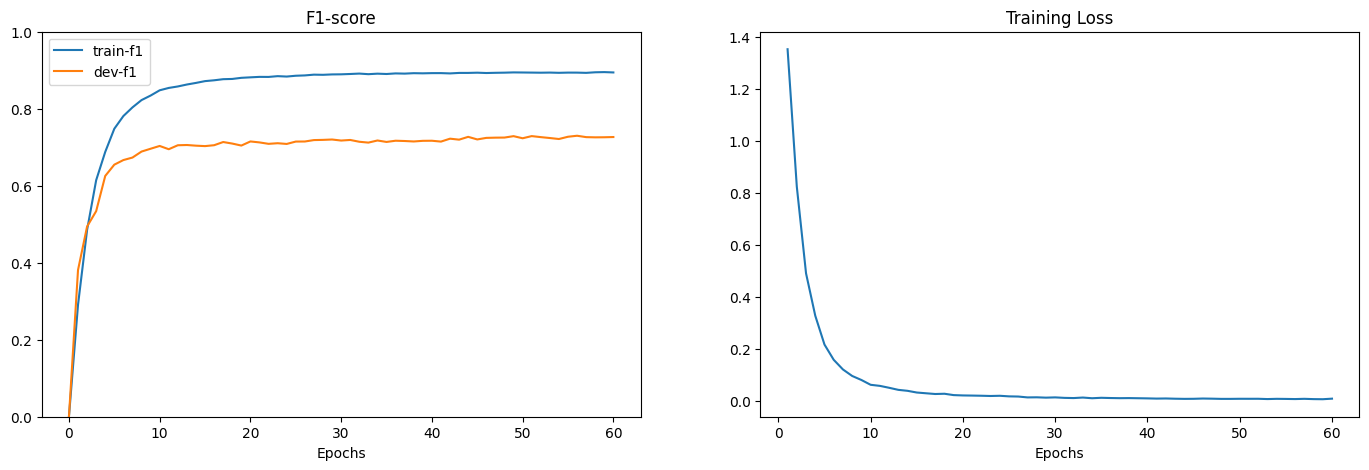

In [11]:
train_f1, dev_f1, losses = train(n_epochs,num_classes,blstmClassifier,criterion,optimizer,tag_enc,train_loader,dev_loader,'blstm1.pt')
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(train_f1)
plt.plot(dev_f1)
plt.legend(['train-f1', 'dev-f1'])
plt.xlabel('Epochs')
plt.title('F1-score')
plt.ylim(0,1)
plt.subplot(122)
plt.plot(losses)
plt.xlabel('Epochs')
plt.title('Training Loss')
plt.savefig("BLSTM.png", pad_inches=0.3, bbox_inches='tight')

In [55]:
from collections import Counter
def metrics(model, dataloader):
    pred=[]
    truth=[]
    for x, y, l, _ in dataloader:
        # print(x)
        outputs = model(x,l)
        # print(outputs.shape)
        predicted = torch.argmax(outputs, 2)
        predicted = [[pred.append(x.item()) for x in p[:t]] for p,t in zip(predicted,l)]
        y = [[truth.append(x.item()) for x in i[:t]] for i,t in zip(y,l)]
    prec = precision_score(truth,pred,labels=list(tag_enc.values()),average='macro',zero_division=0)
    rec = recall_score(truth,pred,labels=list(tag_enc.values()),average='macro',zero_division=0)
    f1 = f1_score(truth,pred,labels=list(tag_enc.values()),average='macro',zero_division=0)
    print(Counter(pred))
    print(Counter(truth))
    return prec, rec, f1

def makeOutput(model, dataloader, raw_data, tag_dec, filename):
    output = []
    for x, y, l, ids in dataloader:
        outputs = model(x,l)
        pred_labels = torch.argmax(outputs, 2)
        if filename[:3]=="dev":
            for predicted,true,siz,id in zip(pred_labels,y,l,ids):
                words = [w for w in raw_data[id]]
                golds = [tag_dec[i.item()] for i in true[:siz]]
                preds = [tag_dec[i.item()] for i in predicted[:siz]]
                [output.append(' '.join([str(i+1),w,g,p,"\n"])) for i,(w,g,p) in enumerate(zip(words,golds,preds))]
                output.append('\n')
        else:
            for predicted,siz,id in zip(pred_labels,l,ids):
                words = [w for w in raw_data[id]]
                # golds = [tag[i.item()] for i in true[:siz]]
                preds = [tag_dec[i.item()] for i in predicted[:siz]]
                [output.append(' '.join([str(i+1),w,p,"\n"])) for i,(w,p) in enumerate(zip(words,preds))]
                output.append('\n')
            
    with open(filename,'w') as f:
        f.writelines(output)


In [12]:
blstmClassifier.load_state_dict(torch.load('blstm1.pt', map_location=device))
prec, rec, f1 = metrics(blstmClassifier,dev_loader)
print("BiLSTM metrics (avg. all classes): prec: {}, \trecall: {}, \tf1: {}".format(prec,rec,f1))

makeOutput(blstmClassifier,dev_loader,X_dev,tag_dec,"dev1.out")
!perl conll03eval.txt < dev1.out
makeOutput(blstmClassifier,test_loader,X_test,tag_dec,"test1.out")

Counter({1: 44749, 5: 1596, 3: 1313, 0: 1091, 4: 982, 2: 785, 6: 560, 7: 267, 8: 235})
Counter({1: 42975, 3: 1842, 5: 1837, 0: 1341, 4: 1307, 2: 922, 6: 751, 7: 346, 8: 257})
BiLSTM metrics (avg. all classes): prec: 0.804737987985751, 	recall: 0.6690867852887132, 	f1: 0.7282223549500613
processed 51578 tokens with 5942 phrases; found: 5037 phrases; correct: 4128.
accuracy:  94.71%; precision:  81.95%; recall:  69.47%; FB1:  75.20
              LOC: precision:  88.52%; recall:  78.50%; FB1:  83.21  1629
             MISC: precision:  84.65%; recall:  74.19%; FB1:  79.08  808
              ORG: precision:  74.09%; recall:  66.74%; FB1:  70.22  1208
              PER: precision:  79.53%; recall:  60.10%; FB1:  68.46  1392


The simple BiLSTM model acheives an F1 score of **75.20%** on the conll evaluation

# Task 2: Using GloVe word embeddings

 - Since the glove embeddings are to be case insensitive, we will encode the input text to the glove embedding after lowering their casing.
 - The original casing information is stored in different embeddings for casing. There are 7 types of casing information along with a padding for the casing encodings.
 - The casing embeddings is concatenated with the word embeddings (from glove) and fed into the BLSTM model.

In [9]:
# Loading the glove embeddings
vocab,embeddings = [],[]
with gzip.open(loc+'glove.6B.100d.gz','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

In [10]:
# case info encoding
casing_enc = {'<pad>':0, 'numeric': 1, 'allLower':2, 'allUpper':3, 'initialUpper':4, 'other':5, 'mainly_numeric':6, 'contains_digit': 7}
embs_casing = np.identity(len(casing_enc), dtype='float32')

vocab_glove = np.array(vocab)
embs_glove = np.array(embeddings)

#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_glove = np.insert(vocab_glove, 0, '<pad>')
vocab_glove = np.insert(vocab_glove, 1, '<unk>')

vocab_glove_enc = {k:v for v,k in enumerate(vocab_glove)}
vocab_glove_dec = list(vocab_glove_enc.keys())

pad_emb_glove = np.zeros((1,embs_glove.shape[1]))   #embedding for '<pad>' token.
unk_emb_glove = np.mean(embs_glove,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_glove = np.vstack((pad_emb_glove,unk_emb_glove,embs_glove))

In [11]:
# Data encoding
def enc_casing(word, caseLookup):   
    casing = 'other'
    
    numDigits = 0
    for char in word:
        if char.isdigit():
            numDigits += 1
            
    digitFraction = numDigits / float(len(word))
    
    if word.isdigit(): #Is a digit
        casing = 'numeric'
    elif digitFraction > 0.5:
        casing = 'mainly_numeric'
    elif word.islower(): #All lower case
        casing = 'allLower'
    elif word.isupper(): #All upper case
        casing = 'allUpper'
    elif word[0].isupper(): #is a title, initial char upper, then all lower
        casing = 'initialUpper'
    elif numDigits > 0:
        casing = 'contains_digit'
    
   
    return caseLookup[casing]

# capturing case information
def enc_case(x,case):
    return np.array([enc_casing(w,case) for w in x])

# making word encoding case insensitive
def enc_sent_case_insensitive(x,voc):
    return np.array([voc.get(w.lower(), voc['<unk>']) for w in x])

# how many samples per batch to load
batch_size = 16

X_train_sent_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent_case_insensitive(x,vocab_glove_enc)) for x in X_train], batch_first=True, padding_value=vocab_glove_enc['<pad>'])
X_train_case_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_case(x,casing_enc)) for x in X_train], batch_first=True, padding_value=casing_enc['<pad>'])
X_train_pad = [[torch.vstack([x1,x2]),len(l)] for x1,x2,l in zip(X_train_sent_pad,X_train_case_pad,X_train)]
y_train_torch = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_tags(y_,tag_enc)) for y_ in y_train], batch_first=True, padding_value=tag_enc['<pad>'])

X_dev_sent_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent_case_insensitive(x,vocab_glove_enc)) for x in X_dev], batch_first=True, padding_value=vocab_glove_enc['<pad>'])
X_dev_case_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_case(x,casing_enc)) for x in X_dev], batch_first=True, padding_value=casing_enc['<pad>'])
X_dev_pad = [[torch.vstack([x1,x2]),len(l)] for x1,x2,l in zip(X_dev_sent_pad,X_dev_case_pad,X_dev)]
y_dev_torch = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_tags(y_,tag_enc)) for y_ in y_dev], batch_first=True, padding_value=tag_enc['<pad>'])

X_test_sent_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent_case_insensitive(x,vocab_glove_enc)) for x in X_test], batch_first=True, padding_value=vocab_glove_enc['<pad>'])
X_test_case_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_case(x,casing_enc)) for x in X_test], batch_first=True, padding_value=casing_enc['<pad>'])
X_test_pad = [[torch.vstack([x1,x2]),len(l)] for x1,x2,l in zip(X_test_sent_pad,X_test_case_pad,X_test)]

train_data = Model_Data(X_train_pad,y_train_torch)
dev_data = Model_Data(X_dev_pad,y_dev_torch)
test_data = Model_Data(X_test_pad,[])

# prepare data loaders
train_loader_glove = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
dev_loader_glove = torch.utils.data.DataLoader(dev_data, batch_size=batch_size)
test_loader_glove = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [12]:
class BLSTMGlove(torch.nn.Module):
    def __init__(self, embs_glove, embs_casing, lstm_inp_size, hidden, n_layers, linear_op_size, n_classes, dropout, pad_case, pad_word):
        super(BLSTMGlove, self).__init__()
        self.hidden_dim = hidden
        self.num_layers = n_layers
        self.emb_casing = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_casing).float(), padding_idx=pad_case)
        self.emb = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_glove).float(), padding_idx=pad_word)
        self.bilstm = torch.nn.LSTM(input_size=lstm_inp_size, hidden_size=hidden, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.drop = torch.nn.Dropout(dropout)
        self.linear1 = torch.nn.Linear(2*hidden, linear_op_size)
        self.elu = torch.nn.ELU()
        self.linear2 = torch.nn.Linear(linear_op_size, n_classes)
        
    def forward(self, x, l):
        x_word_info = self.emb(x.select(1,0))
        x_case_info = self.emb_casing(x.select(1,1))

        x = torch.cat([x_word_info,x_case_info], dim=2)
        
        x_pack = torch.nn.utils.rnn.pack_padded_sequence(x, l, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.bilstm(x_pack)
        lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        x = self.drop(lstm_out)
        x = self.linear1(x)
        x = self.elu(x)
        x = self.linear2(x)
        return x

In [13]:
case_padding = casing_enc['<pad>']
word_padding = vocab_glove_enc['<pad>']
hidden_size=256 
num_layers=1 
linear_op_size=128
num_classes=len(tag_enc.keys())-1 # exclude the padding tag
dropout = 0.33
pad_idx = vocab_enc['<pad>']
lstm_inp_size = embs_glove.shape[1] + embs_casing.shape[1]
class_weights = torch.tensor([(1-v/sum(tags.values())) for v in tags.values()]).to(device)

blstmClassifierGlove = BLSTMGlove(embs_glove, embs_casing, lstm_inp_size, hidden_size, num_layers, linear_op_size, num_classes, dropout, case_padding, word_padding) 
blstmClassifierGlove.to(device)
print(blstmClassifierGlove)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights,ignore_index=tag_enc['<pad>'])
optimizer = torch.optim.SGD(blstmClassifierGlove.parameters(), lr=0.1, momentum=0.9) 
n_epochs = 60

BLSTMGlove(
  (emb_casing): Embedding(8, 8, padding_idx=0)
  (emb): Embedding(400002, 100, padding_idx=0)
  (bilstm): LSTM(108, 256, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.33, inplace=False)
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (elu): ELU(alpha=1.0)
  (linear2): Linear(in_features=128, out_features=9, bias=True)
)


100%|██████████| 937/937 [00:15<00:00, 60.77it/s]


Epoch: 1 of 60, 	Training Loss: 0.615259
Training loss decreased (inf --> 0.615259).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 62.27it/s]


Epoch: 2 of 60, 	Training Loss: 0.287450
Training loss decreased (0.615259 --> 0.287450).  Saving model ...


100%|██████████| 937/937 [00:14<00:00, 63.07it/s]


Epoch: 3 of 60, 	Training Loss: 0.212216
Training loss decreased (0.287450 --> 0.212216).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.88it/s]


Epoch: 4 of 60, 	Training Loss: 0.173271
Training loss decreased (0.212216 --> 0.173271).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.40it/s]


Epoch: 5 of 60, 	Training Loss: 0.139310
Training loss decreased (0.173271 --> 0.139310).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.31it/s]


Epoch: 6 of 60, 	Training Loss: 0.115850
Training loss decreased (0.139310 --> 0.115850).  Saving model ...


100%|██████████| 937/937 [00:14<00:00, 64.20it/s]


Epoch: 7 of 60, 	Training Loss: 0.098534
Training loss decreased (0.115850 --> 0.098534).  Saving model ...


100%|██████████| 937/937 [00:14<00:00, 62.88it/s]


Epoch: 8 of 60, 	Training Loss: 0.083251
Training loss decreased (0.098534 --> 0.083251).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.47it/s]


Epoch: 9 of 60, 	Training Loss: 0.072699
Training loss decreased (0.083251 --> 0.072699).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.46it/s]


Epoch: 10 of 60, 	Training Loss: 0.062758
Training loss decreased (0.072699 --> 0.062758).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.08it/s]


Epoch: 11 of 60, 	Training Loss: 0.055330
Training loss decreased (0.062758 --> 0.055330).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.58it/s]


Epoch: 12 of 60, 	Training Loss: 0.048084
Training loss decreased (0.055330 --> 0.048084).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.30it/s]


Epoch: 13 of 60, 	Training Loss: 0.044040
Training loss decreased (0.048084 --> 0.044040).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.84it/s]


Epoch: 14 of 60, 	Training Loss: 0.038217
Training loss decreased (0.044040 --> 0.038217).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 62.09it/s]


Epoch: 15 of 60, 	Training Loss: 0.034018
Training loss decreased (0.038217 --> 0.034018).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 62.17it/s]


Epoch: 16 of 60, 	Training Loss: 0.029645
Training loss decreased (0.034018 --> 0.029645).  Saving model ...


100%|██████████| 937/937 [00:14<00:00, 62.57it/s]


Epoch: 17 of 60, 	Training Loss: 0.026382
Training loss decreased (0.029645 --> 0.026382).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.24it/s]


Epoch: 18 of 60, 	Training Loss: 0.027570


100%|██████████| 937/937 [00:15<00:00, 60.39it/s]


Epoch: 19 of 60, 	Training Loss: 0.024098
Training loss decreased (0.026382 --> 0.024098).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 59.99it/s]


Epoch: 20 of 60, 	Training Loss: 0.020862
Training loss decreased (0.024098 --> 0.020862).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.15it/s]


Epoch: 21 of 60, 	Training Loss: 0.019207
Training loss decreased (0.020862 --> 0.019207).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.62it/s]


Epoch: 22 of 60, 	Training Loss: 0.016966
Training loss decreased (0.019207 --> 0.016966).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.17it/s]


Epoch: 23 of 60, 	Training Loss: 0.016828
Training loss decreased (0.016966 --> 0.016828).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.74it/s]


Epoch: 24 of 60, 	Training Loss: 0.015281
Training loss decreased (0.016828 --> 0.015281).  Saving model ...


100%|██████████| 937/937 [00:14<00:00, 62.79it/s]


Epoch: 25 of 60, 	Training Loss: 0.012914
Training loss decreased (0.015281 --> 0.012914).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.85it/s]


Epoch: 26 of 60, 	Training Loss: 0.015326


100%|██████████| 937/937 [00:14<00:00, 63.33it/s]


Epoch: 27 of 60, 	Training Loss: 0.013109


100%|██████████| 937/937 [00:14<00:00, 62.49it/s]


Epoch: 28 of 60, 	Training Loss: 0.013303


100%|██████████| 937/937 [00:14<00:00, 62.77it/s]


Epoch: 29 of 60, 	Training Loss: 0.010286
Training loss decreased (0.012914 --> 0.010286).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.75it/s]


Epoch: 30 of 60, 	Training Loss: 0.010483


100%|██████████| 937/937 [00:15<00:00, 60.30it/s]


Epoch: 31 of 60, 	Training Loss: 0.009231
Training loss decreased (0.010286 --> 0.009231).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.83it/s]


Epoch: 32 of 60, 	Training Loss: 0.011042


100%|██████████| 937/937 [00:15<00:00, 60.71it/s]


Epoch: 33 of 60, 	Training Loss: 0.009092
Training loss decreased (0.009231 --> 0.009092).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.24it/s]


Epoch: 34 of 60, 	Training Loss: 0.010273


100%|██████████| 937/937 [00:14<00:00, 62.72it/s]


Epoch: 35 of 60, 	Training Loss: 0.008814
Training loss decreased (0.009092 --> 0.008814).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 62.43it/s]


Epoch: 36 of 60, 	Training Loss: 0.008478
Training loss decreased (0.008814 --> 0.008478).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.25it/s]


Epoch: 37 of 60, 	Training Loss: 0.008124
Training loss decreased (0.008478 --> 0.008124).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.85it/s]


Epoch: 38 of 60, 	Training Loss: 0.009425


100%|██████████| 937/937 [00:14<00:00, 62.59it/s]


Epoch: 39 of 60, 	Training Loss: 0.008971


100%|██████████| 937/937 [00:15<00:00, 61.14it/s]


Epoch: 40 of 60, 	Training Loss: 0.007069
Training loss decreased (0.008124 --> 0.007069).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.46it/s]


Epoch: 41 of 60, 	Training Loss: 0.005748
Training loss decreased (0.007069 --> 0.005748).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.94it/s]


Epoch: 42 of 60, 	Training Loss: 0.007670


100%|██████████| 937/937 [00:15<00:00, 61.75it/s]


Epoch: 43 of 60, 	Training Loss: 0.007370


100%|██████████| 937/937 [00:15<00:00, 62.08it/s]


Epoch: 44 of 60, 	Training Loss: 0.007973


100%|██████████| 937/937 [00:14<00:00, 63.13it/s]


Epoch: 45 of 60, 	Training Loss: 0.006754


100%|██████████| 937/937 [00:15<00:00, 62.36it/s]


Epoch: 46 of 60, 	Training Loss: 0.006773


100%|██████████| 937/937 [00:14<00:00, 62.59it/s]


Epoch: 47 of 60, 	Training Loss: 0.006322


100%|██████████| 937/937 [00:13<00:00, 67.44it/s]


Epoch: 48 of 60, 	Training Loss: 0.005843


100%|██████████| 937/937 [00:14<00:00, 62.81it/s]


Epoch: 49 of 60, 	Training Loss: 0.006361


100%|██████████| 937/937 [00:15<00:00, 61.14it/s]


Epoch: 50 of 60, 	Training Loss: 0.005597
Training loss decreased (0.005748 --> 0.005597).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.22it/s]


Epoch: 51 of 60, 	Training Loss: 0.004750
Training loss decreased (0.005597 --> 0.004750).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.72it/s]


Epoch: 52 of 60, 	Training Loss: 0.004311
Training loss decreased (0.004750 --> 0.004311).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 60.14it/s]


Epoch: 53 of 60, 	Training Loss: 0.004644


100%|██████████| 937/937 [00:15<00:00, 61.59it/s]


Epoch: 54 of 60, 	Training Loss: 0.004710


100%|██████████| 937/937 [00:15<00:00, 61.04it/s]


Epoch: 55 of 60, 	Training Loss: 0.007312


100%|██████████| 937/937 [00:15<00:00, 61.15it/s]


Epoch: 56 of 60, 	Training Loss: 0.004989


100%|██████████| 937/937 [00:15<00:00, 60.56it/s]


Epoch: 57 of 60, 	Training Loss: 0.004175
Training loss decreased (0.004311 --> 0.004175).  Saving model ...


100%|██████████| 937/937 [00:15<00:00, 61.75it/s]


Epoch: 58 of 60, 	Training Loss: 0.004231


100%|██████████| 937/937 [00:15<00:00, 61.41it/s]


Epoch: 59 of 60, 	Training Loss: 0.004680


100%|██████████| 937/937 [00:15<00:00, 60.95it/s]


Epoch: 60 of 60, 	Training Loss: 0.004301


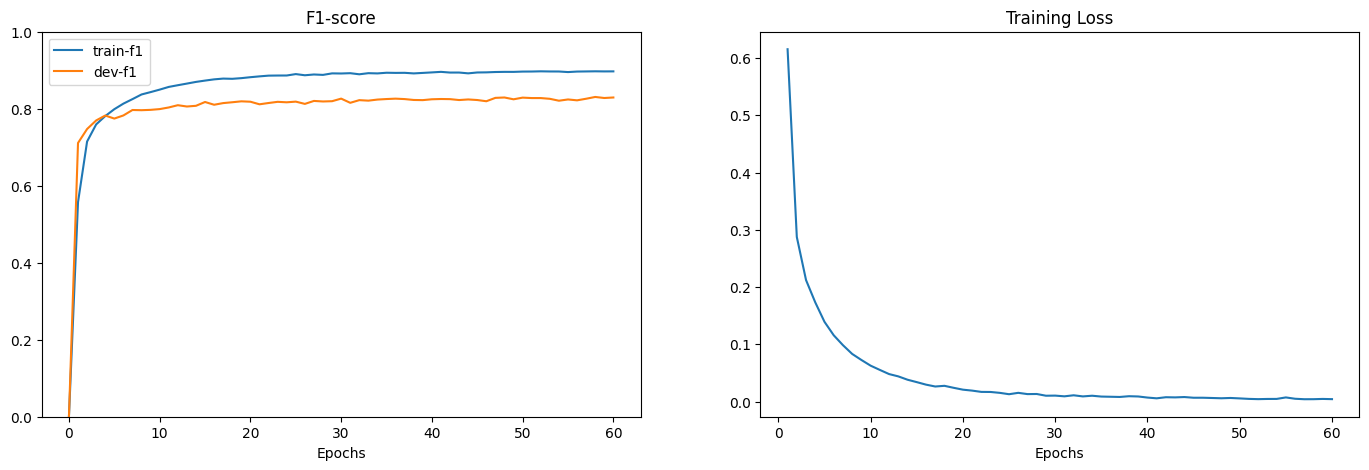

In [19]:
train_f1, dev_f1, losses = train(n_epochs,num_classes,blstmClassifierGlove,criterion,optimizer,tag_enc,train_loader_glove,dev_loader_glove,'blstm2.pt')
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(train_f1)
plt.plot(dev_f1)
plt.legend(['train-f1', 'dev-f1'])
plt.xlabel('Epochs')
plt.title('F1-score')
plt.ylim(0,1)
plt.subplot(122)
plt.plot(losses)
plt.xlabel('Epochs')
plt.title('Training Loss')    
plt.savefig("BLSTMGlove.png", pad_inches=0.3, bbox_inches='tight')

In [20]:
blstmClassifierGlove.load_state_dict(torch.load('blstm2.pt'))
prec, rec, f1 = metrics(blstmClassifierGlove,dev_loader_glove)
print("BiLSTM Glove metrics (avg. all classes): prec: {}, \trecall: {}, \tf1: {}".format(prec,rec,f1))

makeOutput(blstmClassifierGlove,dev_loader_glove,X_dev,tag_dec,"dev2.out")
!perl conll03eval.txt < dev2.out
makeOutput(blstmClassifierGlove,test_loader_glove,X_test,tag_dec,"test2.out")

Counter({1: 43046, 5: 1857, 3: 1849, 4: 1300, 0: 1291, 2: 916, 6: 703, 7: 340, 8: 276})
Counter({1: 42975, 3: 1842, 5: 1837, 0: 1341, 4: 1307, 2: 922, 6: 751, 7: 346, 8: 257})
BiLSTM Glove metrics (avg. all classes): prec: 0.8306525917048149, 	recall: 0.8268933354191574, 	f1: 0.8285192081829393
processed 51578 tokens with 5942 phrases; found: 6058 phrases; correct: 5499.
accuracy:  98.56%; precision:  90.77%; recall:  92.54%; FB1:  91.65
              LOC: precision:  93.74%; recall:  96.19%; FB1:  94.95  1885
             MISC: precision:  84.39%; recall:  86.23%; FB1:  85.30  942
              ORG: precision:  85.87%; recall:  87.02%; FB1:  86.44  1359
              PER: precision:  94.55%; recall:  96.09%; FB1:  95.32  1872


The BiLSTM model with Glove embeddings and Casing embeddings acheives an F1 score of **91.65%** on the conll evaluation

# Bonus: LSTM-CNN model

- For character embeddings to be trained, we encode the character info for each word for each sentence. We need to pack it into a tensor that can be loaded when training.
- Since the character information will be encoded in a 2D matrix, we will have to expand the word embeddings and case embeddings to the same shape so that it can be concatenated and packed in one tensor for the Dataloader. 
- The character encodings are padded to the max length of words seen in the glove dictionary.
- During training, all three encodings are separated and passed into the respective embedding layers and later concatenated after passing to the BLSTM layers.
- The CNN module takes in the char encodings for each word, and pass into 
    - Char embedding layer(inp=char_vocab_size,op=30) -> Conv1d(inp=30,op=40) -> MaxPool1d(longest_word_for_padding)
- This is done for all the sentences in a for loop in the BLSTM module and concatenated with the outputs of word and case embedding.
- The 3 layers of information is passed to the BLSTM layer and the final classifier.

In [14]:
# character infor encoding
char_enc = {"<pad>":0, "<unk>":1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}<>!?:;#'\"/\\%$`&=*+@^~|":
    char_enc[c] = len(char_enc)
    
longest_word_for_padding = max([len(w) for w in vocab_glove_enc.keys()])

In [15]:
# Data encoding
def enc_char_info(x,char):

    def enc_char(w,char):
        return np.array([char.get(c, char['<unk>']) for c in w])

    x_pad = []
    for w in x:
        enc_x = torch.from_numpy(enc_char(w,char))
        # padding with "<pad>":0
        x_pad.append(torch.nn.functional.pad(enc_x,(0,longest_word_for_padding-enc_x.shape[0])))
    
    # length info not required
    # x_out = torch.vstack([torch.hstack([x,torch.tensor(len(w))]) for x,w in zip(x_pad,x)])
    
    return torch.vstack(x_pad)


# how many samples per batch to load
batch_size = 16

# encoding and packing the train data
X_train_sent_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent_case_insensitive(x,vocab_glove_enc)) for x in X_train], batch_first=True, padding_value=vocab_glove_enc['<pad>'])

X_train_case_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_case(x,casing_enc)) for x in X_train], batch_first=True, padding_value=casing_enc['<pad>'])

X_train_char_pad = [enc_char_info(x,char_enc) for x in X_train]
X_train_char_pad = [torch.nn.ConstantPad2d((0,0,0,X_train_sent_pad.shape[1]-x.shape[0]), 0)(x) for x in X_train_char_pad]
X_train_pad = []
for x1,x2,x3,l in zip(X_train_sent_pad,X_train_case_pad,X_train_char_pad,X_train):
    x1 = x1.view(-1, 1).expand(x3.shape)
    x2 = x2.view(-1, 1).expand(x3.shape)
    X_train_pad.append([torch.stack([x1,x2,x3],dim=2),len(l)])

y_train_torch = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_tags(y_,tag_enc)) for y_ in y_train], batch_first=True, padding_value=tag_enc['<pad>'])

# encoding and packing the dev data
X_dev_sent_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent_case_insensitive(x,vocab_glove_enc)) for x in X_dev], batch_first=True, padding_value=vocab_glove_enc['<pad>'])

X_dev_case_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_case(x,casing_enc)) for x in X_dev], batch_first=True, padding_value=casing_enc['<pad>'])

X_dev_char_pad = [enc_char_info(x,char_enc) for x in X_dev]
X_dev_char_pad = [torch.nn.ConstantPad2d((0,0,0,X_dev_sent_pad.shape[1]-x.shape[0]), 0)(x) for x in X_dev_char_pad]
X_dev_pad = []
for x1,x2,x3,l in zip(X_dev_sent_pad,X_dev_case_pad,X_dev_char_pad,X_dev):
    x1 = x1.view(-1, 1).expand(x3.shape)
    x2 = x2.view(-1, 1).expand(x3.shape)
    X_dev_pad.append([torch.stack([x1,x2,x3],dim=2),len(l)])
    
y_dev_torch = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_tags(y_,tag_enc)) for y_ in y_dev], batch_first=True, padding_value=tag_enc['<pad>'])

# encoding and packing the test data
X_test_sent_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_sent_case_insensitive(x,vocab_glove_enc)) for x in X_test], batch_first=True, padding_value=vocab_glove_enc['<pad>'])

X_test_case_pad = torch.nn.utils.rnn.pad_sequence([torch.from_numpy(enc_case(x,casing_enc)) for x in X_test], batch_first=True, padding_value=casing_enc['<pad>'])

X_test_char_pad = [enc_char_info(x,char_enc) for x in X_test]
X_test_char_pad = [torch.nn.ConstantPad2d((0,0,0,X_test_sent_pad.shape[1]-x.shape[0]), 0)(x) for x in X_test_char_pad]
X_test_pad = []
for x1,x2,x3,l in zip(X_test_sent_pad,X_test_case_pad,X_test_char_pad,X_test):
    x1 = x1.view(-1, 1).expand(x3.shape)
    x2 = x2.view(-1, 1).expand(x3.shape)
    X_test_pad.append([torch.stack([x1,x2,x3],dim=2),len(l)])

train_data = Model_Data(X_train_pad,y_train_torch)
dev_data = Model_Data(X_dev_pad,y_dev_torch)
test_data = Model_Data(X_test_pad,[])

# prepare data loaders
train_loader_blstm_cnn = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
dev_loader_blstm_cnn = torch.utils.data.DataLoader(dev_data, batch_size=batch_size)
test_loader_blstm_cnn = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [52]:
class CNN(torch.nn.Module):
    def __init__(self, char_vocab_size, char_emb_dim, cnn_win_size, pad_char, outshape):
        super(CNN, self).__init__()
        
        self.emb_char = torch.nn.Embedding(char_vocab_size, char_emb_dim, padding_idx=pad_char)
        torch.nn.init.xavier_uniform_(self.emb_char.weight)
        self.drop = torch.nn.Dropout(0.5)
        self.cd2 = torch.nn.Conv2d(char_emb_dim, out_channels=outshape, kernel_size=(1,cnn_win_size), padding='same')
        self.maxpool = torch.nn.MaxPool2d((68,1))
        
    def forward(self, x):
        
        x = self.emb_char(x)
        x = self.drop(x)
        # (batch, signal, channel) -> (batch, channel, signal) 
        x = torch.permute(x, (0,3,2,1))
        x = self.cd2(x)
        x = self.maxpool(x)
        x = torch.squeeze(x)
        # (batch, channel, signal) -> (batch, signal, channel) 
        x = torch.permute(x, (0,2,1))
    
        return x
    
class BLSTM_CNN(torch.nn.Module):
    def __init__(self, embs_glove, embs_casing, cnn_out_dim, char_vocab_size, char_emb_dim, cnn_win_size, lstm_inp_size, hidden, n_layers, linear_op_size, n_classes, dropout, pad_char, pad_case, pad_word):
        super(BLSTM_CNN, self).__init__()
        self.hidden_dim = hidden
        self.num_layers = n_layers
        self.cnn_outshape = cnn_out_dim
        
        self.cnn_module = CNN(char_vocab_size, char_emb_dim, cnn_win_size, pad_char, outshape=cnn_out_dim)
        self.emb_casing = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_casing).float(), padding_idx=pad_case)
        self.emb = torch.nn.Embedding.from_pretrained(torch.from_numpy(embs_glove).float(), padding_idx=pad_word)
        self.bilstm = torch.nn.LSTM(input_size=lstm_inp_size, hidden_size=hidden, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.linear1 = torch.nn.Linear(2*hidden, linear_op_size)
        self.elu = torch.nn.ELU()
        self.drop = torch.nn.Dropout(dropout)
        self.linear2 = torch.nn.Linear(linear_op_size, n_classes)
        
    def forward(self, x, l):
        
        x_word_info = self.emb(x.select(-1,0).select(-1,0))
        x_case_info = self.emb_casing(x.select(-1,1).select(-1,0))
        
        # x_char_info = []

        # batch of sentences -> sentence of words -> word of chars
        # time-distributed cnn module
        # for words in x.select(-1,2):
        #     x_char_info.append(self.cnn_module(words).view(-1,self.cnn_outshape))
        
        # x_char_info = torch.stack(x_char_info)
        
        x_char_info = self.cnn_module(x.select(-1,2))
        
        x = torch.cat([x_word_info,x_case_info,x_char_info], dim=2)
        
        x_pack = torch.nn.utils.rnn.pack_padded_sequence(x, l, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.bilstm(x_pack)
        lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        x = self.drop(lstm_out)
        x = self.linear1(x)
        x = self.elu(x)
        x = self.linear2(x)
        return x

In [56]:
cnn_win_size = 3
char_vocab_size = len(char_enc.keys())
char_emb_dim = 30
cnn_out_dim = 20
char_padding = char_enc['<pad>']
case_padding = casing_enc['<pad>']
word_padding = vocab_glove_enc['<pad>']
hidden_size=256 
num_layers=1 
linear_op_size=128
num_classes=len(tag_enc.keys())-1 # exclude the padding tag
dropout = 0.33
pad_idx = vocab_enc['<pad>']
lstm_inp_size = embs_glove.shape[1] + embs_casing.shape[1] + cnn_out_dim
class_weights = torch.tensor([(1-v/sum(tags.values())) for v in tags.values()]).to(device)

BLSTM_CNN_classifier = BLSTM_CNN(embs_glove, embs_casing, cnn_out_dim, char_vocab_size, char_emb_dim, cnn_win_size, lstm_inp_size, hidden_size, num_layers, linear_op_size, num_classes, dropout, char_padding, case_padding, word_padding) 
BLSTM_CNN_classifier.to(device)
print(BLSTM_CNN_classifier)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights,ignore_index=tag_enc['<pad>'])
optimizer = torch.optim.SGD(BLSTM_CNN_classifier.parameters(), lr=0.1, momentum=0.9) 
n_epochs = 60

BLSTM_CNN(
  (cnn_module): CNN(
    (emb_char): Embedding(97, 30, padding_idx=0)
    (drop): Dropout(p=0.5, inplace=False)
    (cd2): Conv2d(30, 20, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (maxpool): MaxPool2d(kernel_size=(68, 1), stride=(68, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (emb_casing): Embedding(8, 8, padding_idx=0)
  (emb): Embedding(400002, 100, padding_idx=0)
  (bilstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (elu): ELU(alpha=1.0)
  (drop): Dropout(p=0.33, inplace=False)
  (linear2): Linear(in_features=128, out_features=9, bias=True)
)


100%|██████████| 937/937 [03:49<00:00,  4.08it/s]


Epoch: 1 of 60, 	Training Loss: 0.607770
Training loss decreased (inf --> 0.607770).  Saving model ...


100%|██████████| 937/937 [05:54<00:00,  2.65it/s]


Epoch: 2 of 60, 	Training Loss: 0.279310
Training loss decreased (0.607770 --> 0.279310).  Saving model ...


100%|██████████| 937/937 [05:06<00:00,  3.06it/s]


Epoch: 3 of 60, 	Training Loss: 0.208544
Training loss decreased (0.279310 --> 0.208544).  Saving model ...


100%|██████████| 937/937 [03:26<00:00,  4.54it/s]


Epoch: 4 of 60, 	Training Loss: 0.165867
Training loss decreased (0.208544 --> 0.165867).  Saving model ...


100%|██████████| 937/937 [03:07<00:00,  4.99it/s]


Epoch: 5 of 60, 	Training Loss: 0.135317
Training loss decreased (0.165867 --> 0.135317).  Saving model ...


100%|██████████| 937/937 [03:54<00:00,  3.99it/s]


Epoch: 6 of 60, 	Training Loss: 0.109755
Training loss decreased (0.135317 --> 0.109755).  Saving model ...


100%|██████████| 937/937 [04:10<00:00,  3.74it/s]


Epoch: 7 of 60, 	Training Loss: 0.091896
Training loss decreased (0.109755 --> 0.091896).  Saving model ...


100%|██████████| 937/937 [08:48<00:00,  1.77it/s]  


Epoch: 8 of 60, 	Training Loss: 0.078904
Training loss decreased (0.091896 --> 0.078904).  Saving model ...


100%|██████████| 937/937 [03:29<00:00,  4.47it/s]


Epoch: 9 of 60, 	Training Loss: 0.067325
Training loss decreased (0.078904 --> 0.067325).  Saving model ...


100%|██████████| 937/937 [03:05<00:00,  5.06it/s]


Epoch: 10 of 60, 	Training Loss: 0.056749
Training loss decreased (0.067325 --> 0.056749).  Saving model ...


100%|██████████| 937/937 [03:38<00:00,  4.29it/s]


Epoch: 11 of 60, 	Training Loss: 0.050195
Training loss decreased (0.056749 --> 0.050195).  Saving model ...


100%|██████████| 937/937 [04:18<00:00,  3.62it/s]


Epoch: 12 of 60, 	Training Loss: 0.042508
Training loss decreased (0.050195 --> 0.042508).  Saving model ...


100%|██████████| 937/937 [04:34<00:00,  3.41it/s]


Epoch: 13 of 60, 	Training Loss: 0.039351
Training loss decreased (0.042508 --> 0.039351).  Saving model ...


100%|██████████| 937/937 [03:46<00:00,  4.14it/s]


Epoch: 14 of 60, 	Training Loss: 0.033622
Training loss decreased (0.039351 --> 0.033622).  Saving model ...


100%|██████████| 937/937 [04:29<00:00,  3.47it/s]


Epoch: 15 of 60, 	Training Loss: 0.032288
Training loss decreased (0.033622 --> 0.032288).  Saving model ...


100%|██████████| 937/937 [03:46<00:00,  4.14it/s]


Epoch: 16 of 60, 	Training Loss: 0.026559
Training loss decreased (0.032288 --> 0.026559).  Saving model ...


100%|██████████| 937/937 [04:04<00:00,  3.83it/s]


Epoch: 17 of 60, 	Training Loss: 0.025442
Training loss decreased (0.026559 --> 0.025442).  Saving model ...


100%|██████████| 937/937 [03:26<00:00,  4.53it/s]


Epoch: 18 of 60, 	Training Loss: 0.021903
Training loss decreased (0.025442 --> 0.021903).  Saving model ...


100%|██████████| 937/937 [03:44<00:00,  4.17it/s]


Epoch: 19 of 60, 	Training Loss: 0.018516
Training loss decreased (0.021903 --> 0.018516).  Saving model ...


100%|██████████| 937/937 [04:00<00:00,  3.90it/s]


Epoch: 20 of 60, 	Training Loss: 0.016884
Training loss decreased (0.018516 --> 0.016884).  Saving model ...


100%|██████████| 937/937 [04:54<00:00,  3.18it/s]


Epoch: 21 of 60, 	Training Loss: 0.016847
Training loss decreased (0.016884 --> 0.016847).  Saving model ...


100%|██████████| 937/937 [04:22<00:00,  3.57it/s]


Epoch: 22 of 60, 	Training Loss: 0.019120


100%|██████████| 937/937 [04:13<00:00,  3.69it/s]


Epoch: 23 of 60, 	Training Loss: 0.016190
Training loss decreased (0.016847 --> 0.016190).  Saving model ...


100%|██████████| 937/937 [03:53<00:00,  4.02it/s]


Epoch: 24 of 60, 	Training Loss: 0.013239
Training loss decreased (0.016190 --> 0.013239).  Saving model ...


100%|██████████| 937/937 [03:26<00:00,  4.54it/s]


Epoch: 25 of 60, 	Training Loss: 0.013160
Training loss decreased (0.013239 --> 0.013160).  Saving model ...


100%|██████████| 937/937 [03:27<00:00,  4.52it/s]


Epoch: 26 of 60, 	Training Loss: 0.016335


100%|██████████| 937/937 [03:22<00:00,  4.63it/s]


Epoch: 27 of 60, 	Training Loss: 0.012822
Training loss decreased (0.013160 --> 0.012822).  Saving model ...


100%|██████████| 937/937 [03:46<00:00,  4.14it/s]


Epoch: 28 of 60, 	Training Loss: 0.010779
Training loss decreased (0.012822 --> 0.010779).  Saving model ...


100%|██████████| 937/937 [04:19<00:00,  3.61it/s]


Epoch: 29 of 60, 	Training Loss: 0.009374
Training loss decreased (0.010779 --> 0.009374).  Saving model ...


100%|██████████| 937/937 [04:05<00:00,  3.82it/s]


Epoch: 30 of 60, 	Training Loss: 0.008669
Training loss decreased (0.009374 --> 0.008669).  Saving model ...


100%|██████████| 937/937 [04:15<00:00,  3.67it/s]


Epoch: 31 of 60, 	Training Loss: 0.007579
Training loss decreased (0.008669 --> 0.007579).  Saving model ...


100%|██████████| 937/937 [03:45<00:00,  4.16it/s]


Epoch: 32 of 60, 	Training Loss: 0.006513
Training loss decreased (0.007579 --> 0.006513).  Saving model ...


100%|██████████| 937/937 [03:20<00:00,  4.68it/s]


Epoch: 33 of 60, 	Training Loss: 0.005908
Training loss decreased (0.006513 --> 0.005908).  Saving model ...


100%|██████████| 937/937 [02:37<00:00,  5.95it/s]


Epoch: 34 of 60, 	Training Loss: 0.005197
Training loss decreased (0.005908 --> 0.005197).  Saving model ...


100%|██████████| 937/937 [02:38<00:00,  5.92it/s]


Epoch: 35 of 60, 	Training Loss: 0.005449


100%|██████████| 937/937 [02:38<00:00,  5.93it/s]


Epoch: 36 of 60, 	Training Loss: 0.005494


100%|██████████| 937/937 [02:37<00:00,  5.97it/s]


Epoch: 37 of 60, 	Training Loss: 0.006244


100%|██████████| 937/937 [02:33<00:00,  6.10it/s]


Epoch: 38 of 60, 	Training Loss: 0.004674
Training loss decreased (0.005197 --> 0.004674).  Saving model ...


100%|██████████| 937/937 [02:36<00:00,  5.97it/s]


Epoch: 39 of 60, 	Training Loss: 0.006243


100%|██████████| 937/937 [02:38<00:00,  5.90it/s]


Epoch: 40 of 60, 	Training Loss: 0.006154


100%|██████████| 937/937 [03:19<00:00,  4.71it/s]


Epoch: 41 of 60, 	Training Loss: 0.004576
Training loss decreased (0.004674 --> 0.004576).  Saving model ...


100%|██████████| 937/937 [03:30<00:00,  4.44it/s]


Epoch: 42 of 60, 	Training Loss: 0.005395


100%|██████████| 937/937 [03:22<00:00,  4.62it/s]


Epoch: 43 of 60, 	Training Loss: 0.005694


100%|██████████| 937/937 [03:22<00:00,  4.63it/s]


Epoch: 44 of 60, 	Training Loss: 0.004062
Training loss decreased (0.004576 --> 0.004062).  Saving model ...


100%|██████████| 937/937 [03:26<00:00,  4.54it/s]


Epoch: 45 of 60, 	Training Loss: 0.004340


100%|██████████| 937/937 [03:23<00:00,  4.60it/s]


Epoch: 46 of 60, 	Training Loss: 0.004568


100%|██████████| 937/937 [03:37<00:00,  4.31it/s]


Epoch: 47 of 60, 	Training Loss: 0.005060


100%|██████████| 937/937 [03:36<00:00,  4.33it/s]


Epoch: 48 of 60, 	Training Loss: 0.004158


100%|██████████| 937/937 [03:23<00:00,  4.60it/s]


Epoch: 49 of 60, 	Training Loss: 0.004916


100%|██████████| 937/937 [03:17<00:00,  4.74it/s]


Epoch: 50 of 60, 	Training Loss: 0.004736


100%|██████████| 937/937 [03:21<00:00,  4.66it/s]


Epoch: 51 of 60, 	Training Loss: 0.004267


100%|██████████| 937/937 [04:01<00:00,  3.89it/s]


Epoch: 52 of 60, 	Training Loss: 0.003808
Training loss decreased (0.004062 --> 0.003808).  Saving model ...


100%|██████████| 937/937 [04:09<00:00,  3.76it/s]


Epoch: 53 of 60, 	Training Loss: 0.003378
Training loss decreased (0.003808 --> 0.003378).  Saving model ...


100%|██████████| 937/937 [04:06<00:00,  3.81it/s]


Epoch: 54 of 60, 	Training Loss: 0.002701
Training loss decreased (0.003378 --> 0.002701).  Saving model ...


100%|██████████| 937/937 [04:16<00:00,  3.65it/s]


Epoch: 55 of 60, 	Training Loss: 0.002888


100%|██████████| 937/937 [11:56:47<00:00, 45.90s/it]    


Epoch: 56 of 60, 	Training Loss: 0.002356
Training loss decreased (0.002701 --> 0.002356).  Saving model ...


100%|██████████| 937/937 [03:34<00:00,  4.38it/s]


Epoch: 57 of 60, 	Training Loss: 0.002909


100%|██████████| 937/937 [03:37<00:00,  4.31it/s]


Epoch: 58 of 60, 	Training Loss: 0.003208


100%|██████████| 937/937 [03:40<00:00,  4.25it/s]


Epoch: 59 of 60, 	Training Loss: 0.004117


100%|██████████| 937/937 [02:54<00:00,  5.38it/s]


Epoch: 60 of 60, 	Training Loss: 0.002084
Training loss decreased (0.002356 --> 0.002084).  Saving model ...


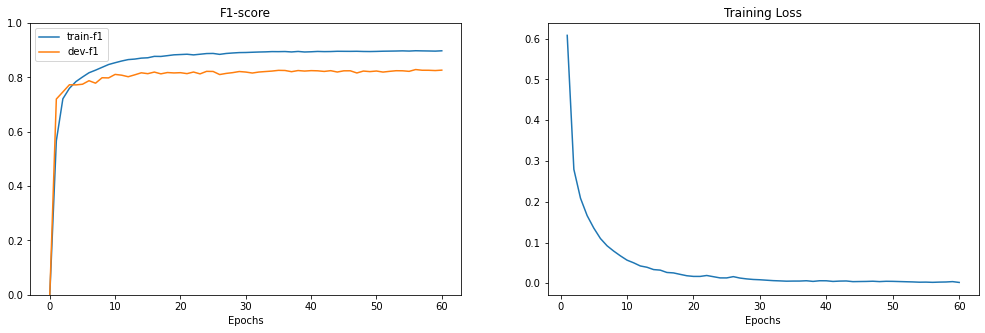

In [57]:
train_f1, dev_f1, losses = train(n_epochs,num_classes,BLSTM_CNN_classifier,criterion,optimizer,tag_enc,train_loader_blstm_cnn,dev_loader_blstm_cnn,'blstm_cnn.pt')
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(train_f1)
plt.plot(dev_f1)
plt.legend(['train-f1', 'dev-f1'])
plt.xlabel('Epochs')
plt.title('F1-score')
plt.ylim(0,1)
plt.subplot(122)
plt.plot(losses)
plt.xlabel('Epochs')
plt.title('Training Loss')
plt.savefig("BLSTM_CNN.png", pad_inches=0.3, bbox_inches='tight')

In [60]:
BLSTM_CNN_classifier.load_state_dict(torch.load('blstm_cnn.pt'))
prec, rec, f1 = metrics(BLSTM_CNN_classifier,dev_loader_blstm_cnn)
print("BiLSTM CNN metrics (avg. all classes): prec (avg. all classes): {}, \trecall: {}, \tf1: {}".format(prec,rec,f1))

makeOutput(BLSTM_CNN_classifier,dev_loader_blstm_cnn,X_dev,tag_dec,"dev_cnn.out")
!perl conll03eval.txt < dev_cnn.out
makeOutput(BLSTM_CNN_classifier,test_loader_blstm_cnn,X_test,tag_dec,"pred")

Counter({1: 42985, 3: 1861, 5: 1817, 0: 1359, 4: 1304, 2: 914, 6: 748, 7: 326, 8: 264})
Counter({1: 42975, 3: 1842, 5: 1837, 0: 1341, 4: 1307, 2: 922, 6: 751, 7: 346, 8: 257})
BiLSTM CNN metrics (avg. all classes): prec (avg. all classes): 0.8304826090659073, 	recall: 0.8279716992081234, 	f1: 0.8291285458168913
processed 51578 tokens with 5942 phrases; found: 6114 phrases; correct: 5511.
accuracy:  98.58%; precision:  90.14%; recall:  92.75%; FB1:  91.42
              LOC: precision:  94.53%; recall:  95.05%; FB1:  94.79  1847
             MISC: precision:  83.09%; recall:  86.88%; FB1:  84.94  964
              ORG: precision:  83.45%; recall:  88.74%; FB1:  86.01  1426
              PER: precision:  94.51%; recall:  96.31%; FB1:  95.40  1877


The BiLSTM model with CNN module for character level information acheives an F1 score of **91.63%** on the conll evaluation